In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import os,sys
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

os.chdir('..')

In [5]:
from src.data_preprocess import DataPreProcessor
preprocessor = DataPreProcessor()

df_raw = preprocessor.fetch_preprocessed_data()
msisdn_to_exclude = 41882819545.02736
df = df_raw[df_raw['MSISDN/Number'] != msisdn_to_exclude]
 

In [6]:
engagement_metrics = df.groupby('MSISDN/Number').agg({'Bearer Id': 'count', 'Dur. (ms)': 'sum', 'Total DL (Bytes)': 'sum', 'Total UL (Bytes)': 'sum'})
engagement_metrics.columns = ['Sessions', 'Duration', 'Total_DL', 'Total_UL']  # Rename columns for clarity
top_10_sessions = engagement_metrics['Sessions'].nlargest(10)
top_10_duration = engagement_metrics['Duration'].nlargest(10)
top_10_traffic = (engagement_metrics['Total_DL'] + engagement_metrics['Total_UL']).nlargest(10)  # Calculate total traffic


In [7]:
print("Top 10 customers by sessions:")
print(top_10_sessions)
print("\nTop 10 customers by session duration:")
print(top_10_duration)
print("\nTop 10 customers by total traffic:")
print(top_10_traffic)


Top 10 customers by sessions:
MSISDN/Number
3.362632e+10    18
3.361489e+10    17
3.362578e+10    17
3.365973e+10    16
3.367588e+10    15
3.376054e+10    15
3.366716e+10    13
3.360313e+10    12
3.360452e+10    12
3.362708e+10    12
Name: Sessions, dtype: int64

Top 10 customers by session duration:
MSISDN/Number
3.362578e+10    18553754.0
3.361489e+10     9966898.0
3.376054e+10     9279434.0
3.362632e+10     8791927.0
3.366716e+10     8744914.0
3.366284e+10     6614270.0
3.366469e+10     6288730.0
3.360313e+10     6287761.0
3.366746e+10     5649882.0
3.376041e+10     5321667.0
Name: Duration, dtype: float64

Top 10 customers by total traffic:
MSISDN/Number
3.361489e+10    8.846226e+09
3.376054e+10    8.514774e+09
3.362578e+10    8.499621e+09
3.362632e+10    7.971167e+09
3.367588e+10    7.891111e+09
3.365973e+10    7.705863e+09
3.366646e+10    7.308501e+09
3.376041e+10    7.132371e+09
3.366471e+10    6.872018e+09
3.369879e+10    6.540899e+09
dtype: float64


In [8]:
scaler = StandardScaler()
engagement_normalized = scaler.fit_transform(engagement_metrics)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(engagement_normalized)
engagement_metrics['Cluster'] = kmeans.labels_

In [9]:
cluster_summary = engagement_metrics.groupby('Cluster').agg({
    'Sessions': ['min', 'max', 'mean', 'sum'],
    'Duration': ['min', 'max', 'mean', 'sum'],
    'Total_DL': ['min', 'max', 'mean', 'sum'],
    'Total_UL': ['min', 'max', 'mean', 'sum']
})
print("\nCluster summary:")
print(cluster_summary)



Cluster summary:
        Sessions                      Duration                             \
             min max      mean    sum      min         max           mean   
Cluster                                                                     
0              1   4  2.164352  53308  18235.0   1573420.0  209733.014738   
1              1   2  1.011050  79420   7142.0   1042254.0  103284.036905   
2              2  18  4.411268  16207  66594.0  18553754.0  636893.259662   

                          Total_DL                                            \
                  sum          min           max          mean           sum   
Cluster                                                                        
0        5.165724e+09   65270746.0  2.409217e+09  9.892445e+08  2.436509e+13   
1        8.113168e+09    8827082.0  9.678157e+08  4.548535e+08  3.572965e+13   
2        2.339946e+09  404647470.0  8.156743e+09  2.072631e+09  7.614845e+12   

           Total_UL                   

In [16]:
# Step 4: Aggregate user total traffic per application and derive the top 10 most engaged users per application
# Let's assume the column names for each application
app_columns = ['Social Media', 'Google', 'Email', 'Netflix', 'Gaming', 'Youtube', 'Other']

# Create a dictionary to map each application to its corresponding columns
app_column_mapping = {
    'Social Media': ['Social Media DL (Bytes)', 'Social Media UL (Bytes)'],
    'Google': ['Google DL (Bytes)', 'Google UL (Bytes)'],
    'Email': ['Email DL (Bytes)', 'Email UL (Bytes)'],
    'Youtube': ['Youtube DL (Bytes)', 'Youtube UL (Bytes)'],
    'Netflix': ['Netflix DL (Bytes)', 'Netflix UL (Bytes)'],
    'Gaming': ['Gaming DL (Bytes)', 'Gaming UL (Bytes)'],
    'Other': ['Other DL (Bytes)', 'Other UL (Bytes)']
}

# Initialize an empty DataFrame to store the aggregated data
app_traffic = pd.DataFrame()

# Iterate through each application
for app, columns in app_column_mapping.items():
    # Calculate the total traffic for each application by summing the corresponding columns
    app_traffic[app] = df[columns].sum(axis=1)

# Aggregate total traffic per application per user (MSISDN/Number)
app_traffic['Total Traffic'] = app_traffic.sum(axis=1)
app_traffic['MSISDN/Number'] = df['MSISDN/Number']

# Group by MSISDN/Number and find the top 10 most engaged users per application
top_10_app_users = app_traffic.groupby('MSISDN/Number').sum().nlargest(10, 'Total Traffic')

# Now let's proceed with plotting the top 3 most used applications


<Figure size 1000x600 with 0 Axes>

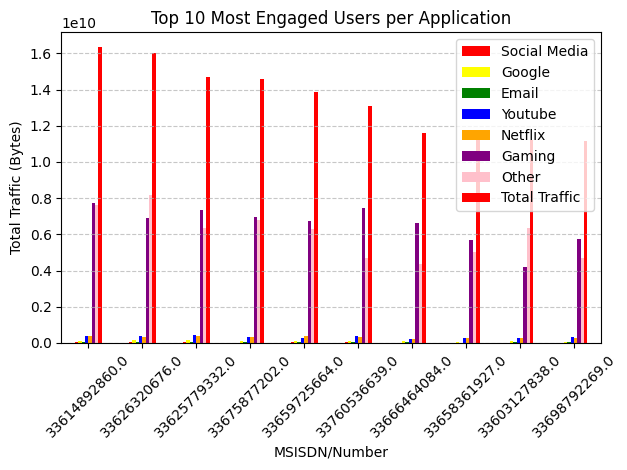

In [13]:
colors = ['red', 'yellow', 'green', 'blue', 'orange', 'purple', 'pink']

plt.figure(figsize=(10, 6))
top_10_app_users.plot(kind='bar', color=colors)
plt.title('Top 10 Most Engaged Users per Application')
plt.xlabel('MSISDN/Number')
plt.ylabel('Total Traffic (Bytes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

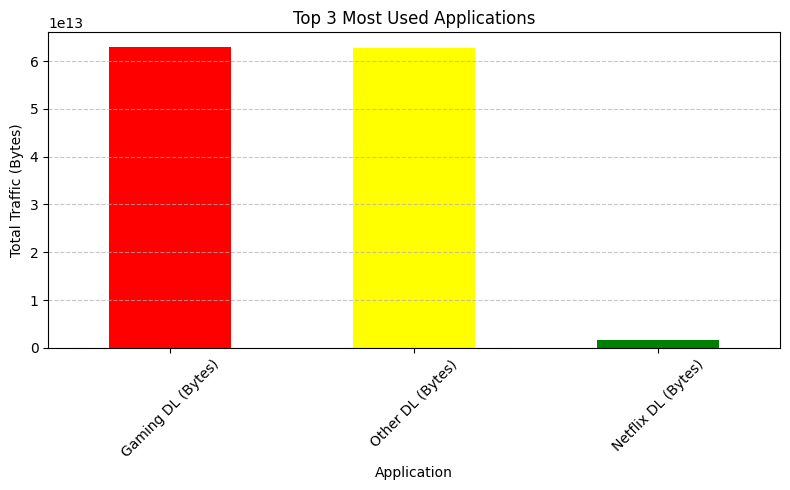

In [14]:
# Define the list of application columns
app_columns = ['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
               'Google DL (Bytes)', 'Google UL (Bytes)',
               'Email DL (Bytes)', 'Email UL (Bytes)',
               'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
               'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
               'Other DL (Bytes)', 'Other UL (Bytes)']

# Step 4: Aggregate total traffic per application
app_traffic = df[app_columns].sum()

# Select top 3 most used applications
top_3_apps = app_traffic.nlargest(3)

# Plot top 3 apps
plt.figure(figsize=(8, 5))
top_3_apps.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


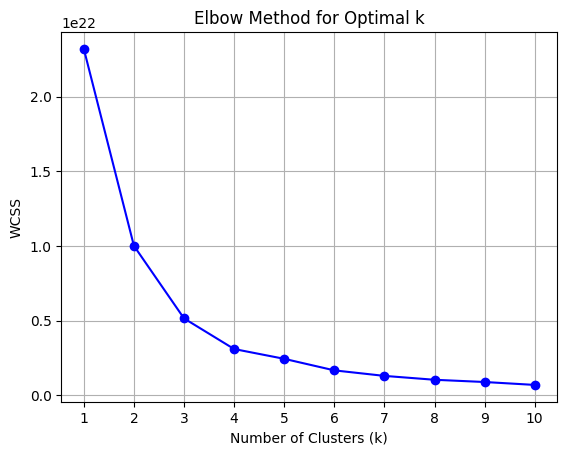

In [15]:
k_values = range(1, 11)

# Compute the within-cluster sum of squares (WCSS) for each value of k
wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(engagement_metrics)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()
